<a href="https://colab.research.google.com/github/DeltaINKDesign/Keras/blob/master/convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#%tensorflow_version 1.x
import keras
import os
from keras import backend as K
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import tensorflow as tf
from keras.utils import to_categorical

#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Using TensorFlow backend.


# Gather the data

In [3]:
# load CIFAR 10 images
# description of this dataset can be seen here:
# https://www.cs.toronto.edu/~kriz/cifar.html

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [9]:
# both X and y are numpy arrays
# the most essential infomation about numpy arrays is in their shape
X_train.shape

(50000, 32, 32, 3)

Label number for that class: [7]


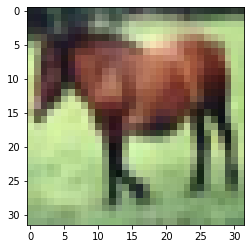

In [10]:
# assign seventh example from training batch to variable called "example_img"
example_img = deepcopy(X_train[7])
print('Label number for that class:', y_train[7])
# display img
plt.imshow(example_img)

In [11]:
# print the shape of example_img
example_img.shape

(32, 32, 3)

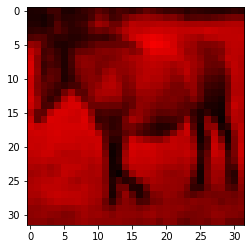

In [27]:
# extract first channel from example_img and assign it to 'red_channel' variable
# red_channel var shape should be (32, 32)
red_channel = example_img[:, :, 0]
assert red_channel.shape == (32, 32)
plt.imshow(np.concatenate([red_channel[..., None], 
                           np.zeros(shape=(32, 32, 2), dtype='int')], axis=-1))

In [0]:
##TODO
# flatten the X_train examples ((50000, 32, 32, 3) -> (50000, 3072))
# hint: you can use numpy reshape function
X_train_flat = X_train.reshape(50000, 3072)
assert X_train_flat.shape == (50000, 3072)

##TODO
# convert the X_train_flat array value range from (0; 255) to (0; 1)
X_train_flat = X_train_flat / 255.
assert np.max(X_train_flat) <= 1.

##TODO
# convert y_train to one hot encoding
# hint: you can use keras.utils.to_categorical function
y = keras.utils.to_categorical(y_train)
assert y.shape == (50000, 10)

# Image classifier (dense neural network)

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
# build a dense neural architecture that receives input vector of length 3072
# and outputs prediction for 10 classes (softmax activation)
# use Adam optimizer, categorical_crossentropy loss
# our metrics will be accuracy

dense_network = Sequential()
dense_network.add(Dense(256, input_shape=(3072,), activation='relu'))
dense_network.add(Dense(10, activation='softmax'))
##TODO build your dense network !

dense_network.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
dense_network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                30730     
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________


In [0]:
##TODO
# train your network
# use batch size 32, split the dataset into train/validation (0.7/0.3)
# keep training for 10 epochs
dense_network.fit(epochs=50, 
                  x=X_train_flat, 
                  y=y, 
                  batch_size=32, 
                  validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 1s 20us/step - loss: 1.6812 - accuracy: 0.3870 - val_loss: 1.7507 - val_accuracy: 0.3633
Epoch 2/50
40000/40000 [==============================] - 1s 17us/step - loss: 1.6835 - accuracy: 0.3859 - val_loss: 1.7530 - val_accuracy: 0.3633
Epoch 3/50
40000/40000 [==============================] - 1s 15us/step - loss: 1.6857 - accuracy: 0.3845 - val_loss: 1.7550 - val_accuracy: 0.3616
Epoch 4/50
40000/40000 [==============================] - 1s 15us/step - loss: 1.6875 - accuracy: 0.3844 - val_loss: 1.7568 - val_accuracy: 0.3612
Epoch 5/50
40000/40000 [==============================] - 1s 15us/step - loss: 1.6891 - accuracy: 0.3832 - val_loss: 1.7582 - val_accuracy: 0.3607
Epoch 6/50
40000/40000 [==============================] - 1s 15us/step - loss: 1.6904 - accuracy: 0.3825 - val_loss: 1.7594 - val_accuracy: 0.3609
Epoch 7/50
40000/40000 [==============================] - 1s 15us/st

In [0]:
def show_random_prediction(x, y, model):
  pool = len(x)
  random_int = np.random.randint(low=0, high=pool)
  if len(model.input.shape) == 2:
    sample = x[random_int].reshape(1, -1)
  else:
    sample = x[random_int][None, ...]
  prediction = model.predict(sample)
  plt.figure(figsize=(2, 2))
  plt.imshow(x[random_int])
  print('Predicted label:', np.argmax(prediction))
  print('Actual label:', y[random_int][0])

Predicted label: 0
Actual label: 0


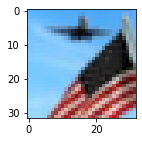

In [0]:
# rerun this cell to show random predictions
show_random_prediction(X_train, y_train, dense_network)

# Convolutions

In [0]:
# write a fuction that converts RGB images (32, 32, 3) to grayscale (32, 32)
# you can just take an average of all channels (easy way)
# the more elegant method is to extract weighted average (luminosity method)
# the weights are: 0.29 R + 0.58 G + 0.11 B
def rgb2gray(img):
  R, G, B = img[:, :, 0], img[:, :, 1], img[:, :, 2]
  return 0.29 * R + 0.58 * G + 0.11 * B

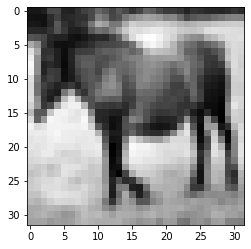

In [0]:
example_img_gray = rgb2gray(example_img)
plt.imshow(example_img_gray, cmap='gray')

In [0]:
# we will create convolutional filter using keras.layers.Conv2D class
from keras.layers import Conv2D

conv_filter = Sequential()
##TODO
# add one convolutional layer that will be a single filter of kernel size = 3
# use 'valid' padding and set the name parameter as 'convolution'
# remember to set input_shape (but now it will be 3-dimensional)
conv_filter.add(Conv2D())

In [0]:
# reshape example_img_gray to include also batch size
example_img_gray = example_img_gray.reshape(1, 32, 32, 1)

In [0]:
# display how conv_filter changes image
result = conv_filter.predict(example_img_gray).reshape(30, 30)
plt.imshow(result, cmap='gray')

In [0]:
# print conv_filter weights
conv_filter.get_layer(name='convolution').get_weights()

In [0]:
# let's define custom kernel! 
# Some of useful kernel patterns are presented here: 
# https://en.wikipedia.org/wiki/Kernel_(image_processing)
# ofc you can define your own values
# for the example, I'll use edge detection kernel
kernel = np.array([
                   [0, 1, 0], 
                   [1, -4, 1],
                   [0, 1, 0]
])

# as you can see above, extracted parameters from Conv2D layer are a list
# The list has two elements:

# first one is actual convolutional kernel of shape (k, k, n, m)
# where k is a kernel size
# n is number of channels in previous layer
# m is number of channels in actual layer

# the second element of Conv2D parameters list is just a bias parameter
# we will set it to 0. for the experiment
kernel = [kernel.reshape(3, 3, 1, 1), np.array([0.])]

In [0]:
conv_filter.get_layer(name='convolution').set_weights(kernel)

In [8]:
conv_filter.get_layer(name='convolutions').get_weights()

NameError: ignored

In [0]:
# display image processed by your custom filter
result = conv_filter.predict(example_img_gray).reshape(30, 30)
plt.imshow(result, cmap='gray')

# LeNet
![alt text](https://miro.medium.com/max/1700/1*AwJZkWLKabIicUPzSN6KCg.png)

In [0]:
from keras.layers.pooling import MaxPool2D
from keras.layers import Flatten, Conv2D, Dense
from keras.models import Sequential
# build your LeNet model !

LeNet = Sequential()
LeNet.add(Conv2D(filters=6, kernel_size=5, activation='relu', input_shape=(32, 32, 3)))
LeNet.add(MaxPool2D())
LeNet.add(Conv2D(filters=16, kernel_size=5, activation='relu'))
LeNet.add(MaxPool2D())
LeNet.add(Flatten())
LeNet.add(Dense(120, activation='relu'))
LeNet.add(Dense(84, activation='relu'))
LeNet.add(Dense(10, activation='softmax'))

In [0]:
example = X_train[0].reshape(1, 32, 32, 3)

In [0]:
result = LeNet.predict(example)

In [0]:
result

array([[8.6232219e-29, 2.3817610e-13, 1.5633797e-02, 1.8564396e-24,
        1.9291572e-29, 9.8436618e-01, 2.6427485e-20, 6.7159961e-16,
        2.5122427e-27, 5.1857469e-29]], dtype=float32)

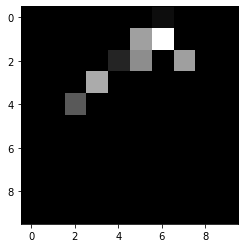

In [0]:
plt.imshow(result[0, :, :, 15], cmap='gray')

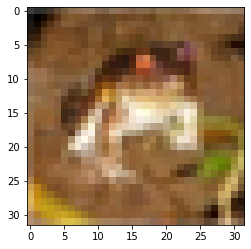

In [0]:
plt.imshow(example[0, :, :, :])

In [0]:
# print summary of your ConvNet
LeNet.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_2 (Dense)              (None, 84)               

In [0]:
from keras.optimizers import Adam
# compile your model, using:
# 1. Categorical crossentropy loss
# 2. Accuracy metric
# 3. Any optimizer you want (in most cases Adam provides good performance)
LeNet.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [0]:
# now use X_train as feature data (since it is not flattened)
# do not flatten, keep 4 dimensions (#examples, width, height, #channels)
# the only thing to do is to reduce the value range from (0; 255) to (0; 1)
# last time we did the normalization for 'X_train_flat', not 'X_train'
X_train = X_train / 255.

In [0]:
# if you still have 'y' variable saved as one hot encoded labels, keep going
# otherwise just run this cell
y = keras.utils.to_categorical(y_train)

In [0]:
# now train your LeNet with the X_train and y
# leave the rest of parameters the same (as for Dense), so you can compare
# which network learns better
LeNet.fit(x=X_train, y=y, batch_size=32, validation_split=0.2, epochs=20)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 6s 158us/step - loss: 1.3757 - accuracy: 0.5003 - val_loss: 1.3176 - val_accuracy: 0.5255
Epoch 2/20
40000/40000 [==============================] - 6s 157us/step - loss: 1.2637 - accuracy: 0.5443 - val_loss: 1.2612 - val_accuracy: 0.5507
Epoch 3/20
40000/40000 [==============================] - 6s 157us/step - loss: 1.1841 - accuracy: 0.5741 - val_loss: 1.2258 - val_accuracy: 0.5647
Epoch 4/20
40000/40000 [==============================] - 6s 158us/step - loss: 1.1211 - accuracy: 0.6001 - val_loss: 1.2026 - val_accuracy: 0.5724
Epoch 5/20
40000/40000 [==============================] - 6s 156us/step - loss: 1.0663 - accuracy: 0.6205 - val_loss: 1.1644 - val_accuracy: 0.5898
Epoch 6/20
40000/40000 [==============================] - 6s 155us/step - loss: 1.0226 - accuracy: 0.6361 - val_loss: 1.2267 - val_accuracy: 0.5695
Epoch 7/20
40000/40000 [==============================] - 6s 1

In [0]:
# rerun this cell to show random predictions
show_random_prediction(X_train, y_train, LeNet)

# Inception
![alt text](https://miro.medium.com/max/1920/1*gqKM5V-uo2sMFFPDS84yJw.png)

In [0]:
from keras.applications.inception_v3 import InceptionV3
from matplotlib.image import imread
from cv2 import resize, flip

# Data preparation

For higher-resolution images example I've prepared dataset from Kaggle: https://www.kaggle.com/slothkong/10-monkey-species.
The dataset contains ~1.5k images of 10 monkey species. Code below preprocess this images to feed and fine-tune Inception for monkey classification task.

Ofc you can use your own idea for fine-tuning task. Feel free to improvise, otherwise you can play with the code below.

In [0]:
! git clone https://github.com/Drpulti/monkey_images.git

Cloning into 'monkey_images'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 1304 (delta 0), reused 2 (delta 0), pack-reused 1299
Receiving objects: 100% (1304/1304), 500.01 MiB | 45.58 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (1373/1373), done.


In [0]:
import pandas as pd
monkey_labels = pd.read_csv('monkey_images/monkey_labels.txt')

In [0]:
# this DataFrame needs some preprocessing because it's messy
monkey_labels.iloc[:, 0] = monkey_labels.iloc[:, 0].apply(lambda x: x.split()[0])
monkey_labels.iloc[:, 2] = monkey_labels.iloc[:, 2].apply(lambda x: x.split()[0])

In [1]:
labels_dict = dict(zip(monkey_labels.iloc[:, 0], monkey_labels.iloc[:, 2]))
labels_ids = dict(zip(monkey_labels.iloc[:, 0], range(len(monkey_labels))))

NameError: ignored

In [0]:
def crop_and_resize(img, width, height):
  w, h, c = img.shape
  if w-h == 0:
    return resize(img, (width, height))
  if w > h:
    diff = w-h
    img = img[diff//2:-diff//2, :, :]
  else:
    diff = h-w
    img = img[:, diff//2:-diff//2, :]
  return resize(img, (width, height))

In [0]:
# target image resolution would be (299, 299). It's the inception's input size
width = 299
height = 299
train_path = 'monkey_images/training/training/'

# placeholders for image data and labels
images = []
labels = []

for directory in os.listdir(train_path):
  print(directory)
  for img in os.listdir(train_path + directory):
    img = imread(train_path + directory + '/' + img)
    img = crop_and_resize(img, width, height)
    images.append(img)
    labels.append(labels_ids[directory])

    # add also mirrored version of training image, to increase image pool size
    images.append(flip(img, 1))
    labels.append(labels_ids[directory])

n1
n3
n8
n5
n9
n2
n4
n7
n0
n6


In [0]:
# load validation images, this time we won't augment the data
# it would corrupt the results
validation_path = 'monkey_images/validation/validation/'
val_images = []
val_labels = []

for directory in os.listdir(validation_path):
  print(directory)
  for img in os.listdir(validation_path + directory):
    img = imread(validation_path + directory + '/' + img)
    img = crop_and_resize(img, width, height)
    val_images.append(img)
    val_labels.append(labels_ids[directory])

n1
n3
n8
n5
n9
n2
n4
n7
n0
n6


In [0]:
images = np.array(images)
labels = np.array(labels).reshape(-1, 1)

val_images = np.array(val_images)
val_labels = np.array(val_labels).reshape(-1, 1)

In [0]:
images = images / 255.
labels = to_categorical(labels)

val_images = val_images / 255.
val_labels = to_categorical(val_labels)

In [0]:
from sklearn.utils import shuffle
images, labels = shuffle(images, labels)

# Inception fine-tuning

In [21]:
inception = InceptionV3(include_top=False, 
                        weights='imagenet', 
                        input_shape=(299, 299, 3))

# freeze most of the Inception layers, leave only the last ones as 'Trainable'
for layer in inception.layers[:-5]:
  layer.trainable = False

NameError: ignored

In [0]:
# uncomment if you want to print Inception layers
# inception.summary()

In [0]:
custom_inception = Sequential()
custom_inception.add(inception)
custom_inception.add(Flatten())
custom_inception.add(Dense(10, activation='softmax'))

In [0]:
custom_inception.summary()

In [0]:
custom_inception.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
custom_inception.fit(x=images, y=labels, batch_size=16, epochs=20, validation_data=(val_images, val_labels))